## Paso 1: Carga y visualizado de datos
Vamos a cargar los datos de olivetti_faces.csv y vamos a crear una función que nos permita ver la imagen cargada en un grid 64x64 a escalas de grises

In [38]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
df = pd.read_csv("../../../datos/olivetti_faces.csv")
df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.68595,...,0.665289,0.669422,0.652893,0.661157,0.475207,0.132231,0.14876,0.152893,0.161157,0.157025


In [40]:
def display_face(face):
    """
    Dibuja una imagen en escala de grises basada en una fila de un archivo CSV donde cada columna representa un píxel.
    Cada fila debe de tener 4096 columnas y será formateada a una imagen de 64x64.
    Parámetros:
    face (Dataframe): fila del Dataframe a mostrar por pantalla
    """
    # Seleccionar la fila deseada y convertirla a un array
    face_data = face.values
    
    # Reformar los datos en la resolución deseada
    face_data = face_data.reshape(64,64)
    
    # Mostrar la imagen
    plt.figure(figsize=(6, 6))
    plt.imshow(face_data, cmap='gray', interpolation='nearest')
    plt.axis('off')  # Ocultar los ejes
    plt.show()

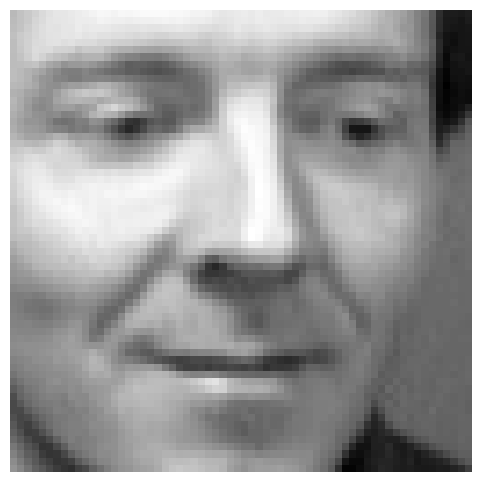

In [41]:
display_face(df.iloc[22])

## Paso 2: Reducción de la dimensionalidad de los datos mediante PCA
Vamos a aplicar PCA para reducir los datos conservando un 99% de la varianza

In [42]:
from sklearn.decomposition import PCA

# Aplicamos PCA para que conserve el 99% de la varianza
pca = PCA(n_components=0.99)
df_reduced = pca.fit_transform(df)

# Miramos la compresión realizada

print(df.shape)
print(df_reduced.shape)

(400, 4096)
(400, 260)


Como podemos apreciar, nos reduce los componentes a solo 260 puntos, esto significa que PCA agrupa la mayoría de píxeles cercanos y calcula que no cambian demasiado los datos.
Vamos a agrupar las caras reducidas con K-means y luego vamos a cargar el valor original para visualizar los grupos y valorarlo de forma manual.

Grupo 0


<Figure size 1500x2400 with 0 Axes>

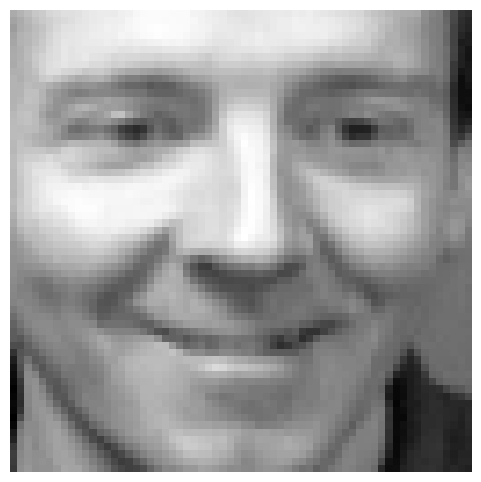

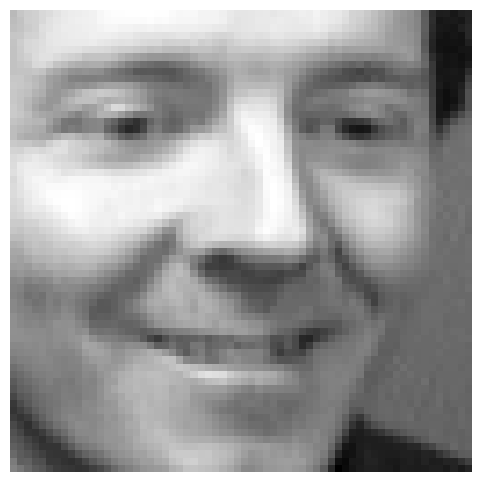

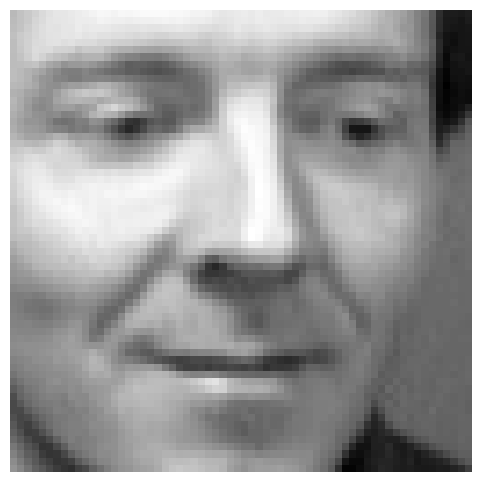

Grupo 1


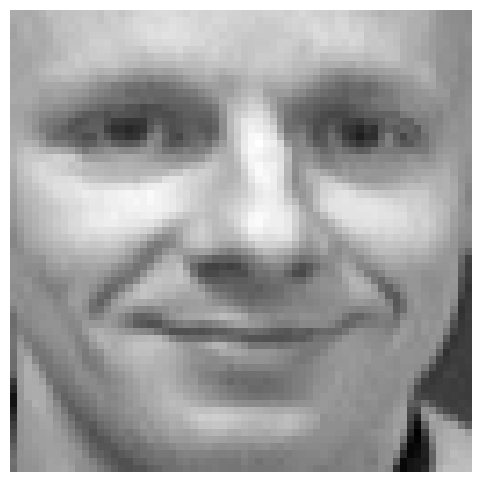

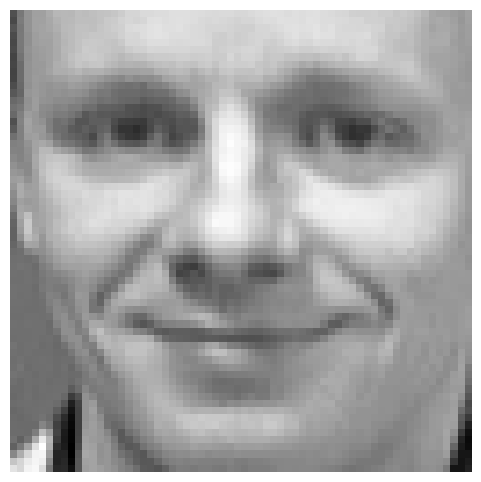

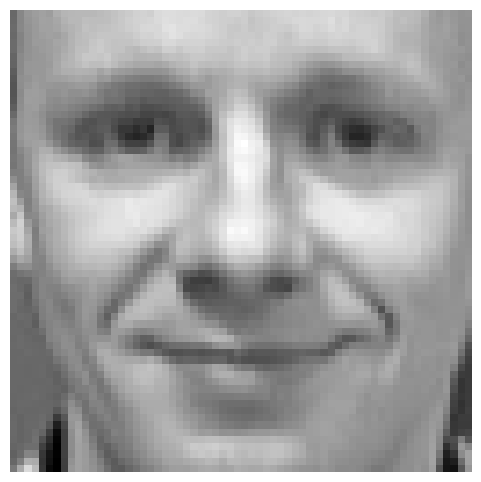

Grupo 2


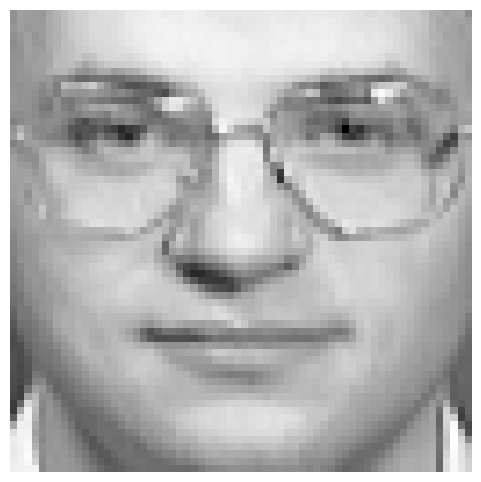

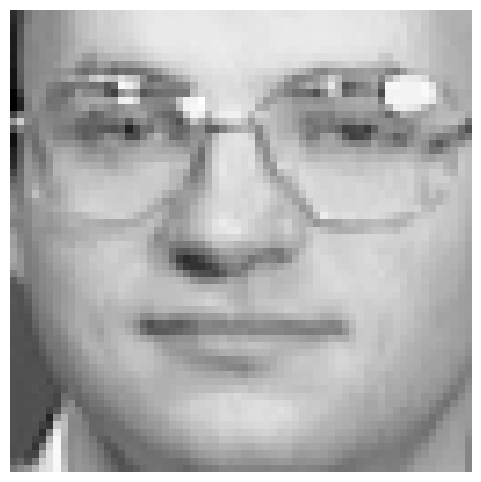

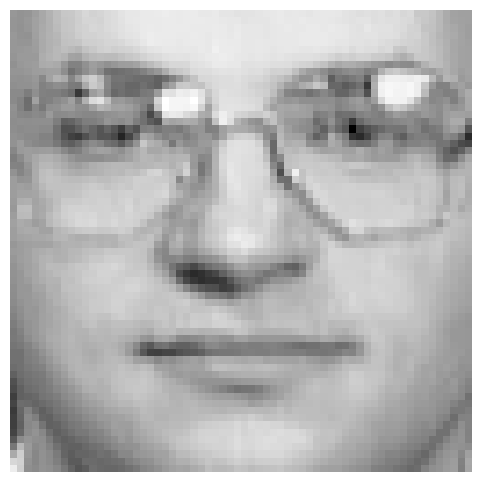

Grupo 3


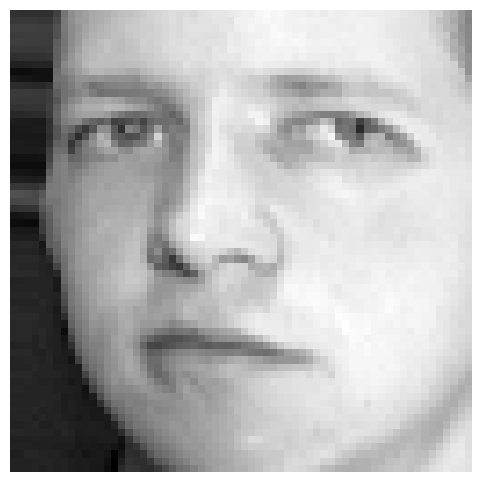

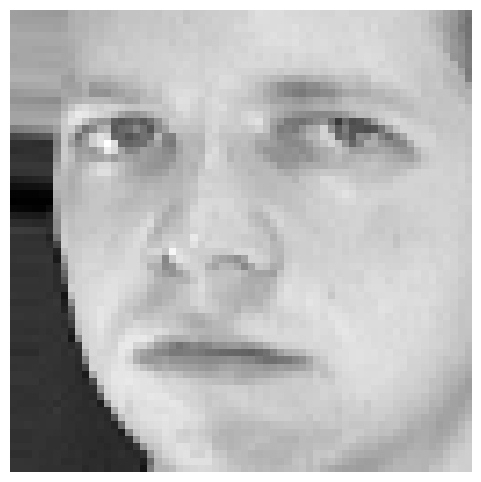

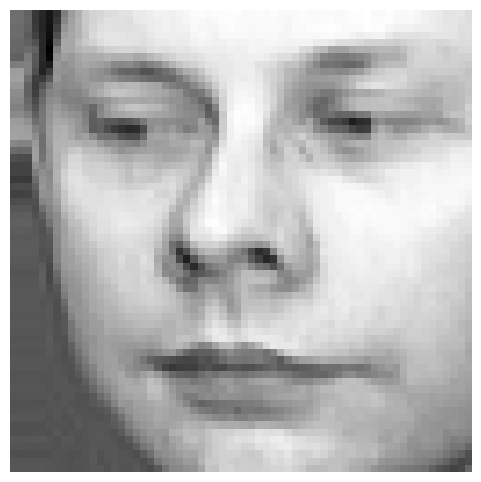

Grupo 4


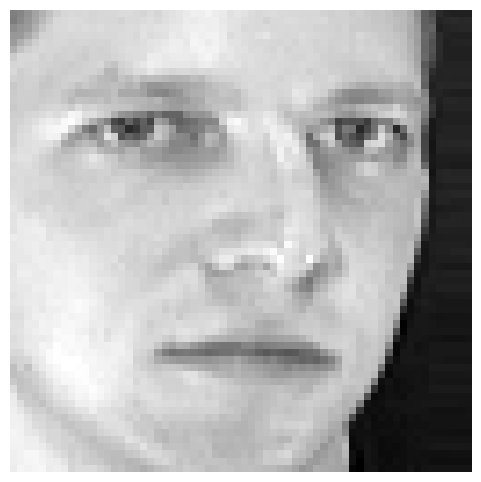

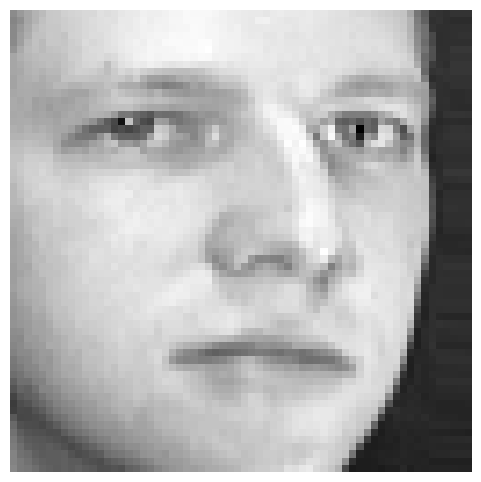

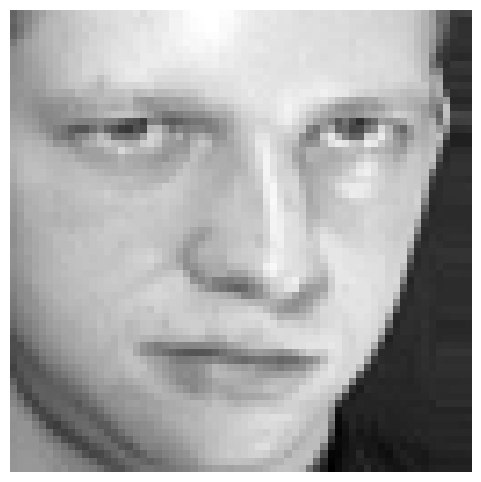

Grupo 5


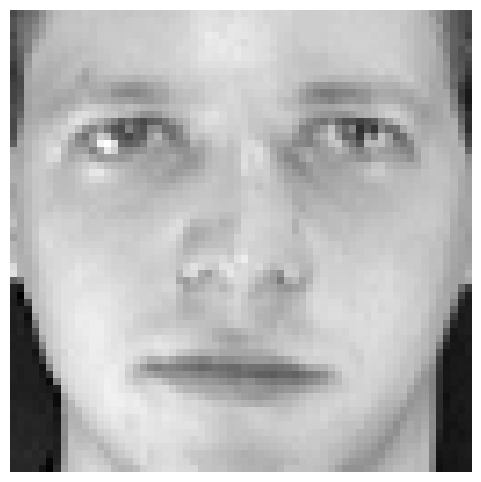

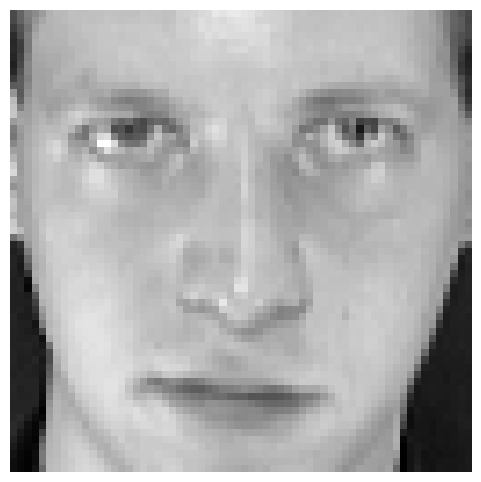

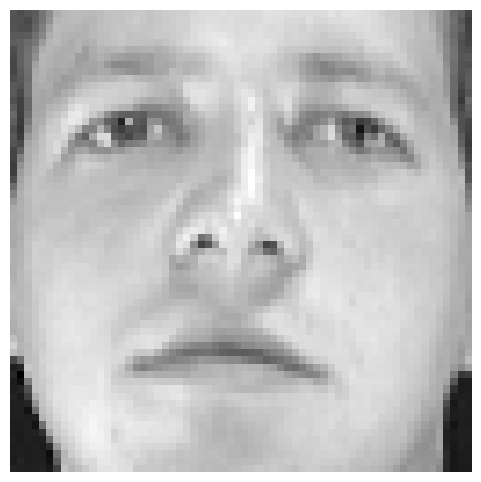

Grupo 6


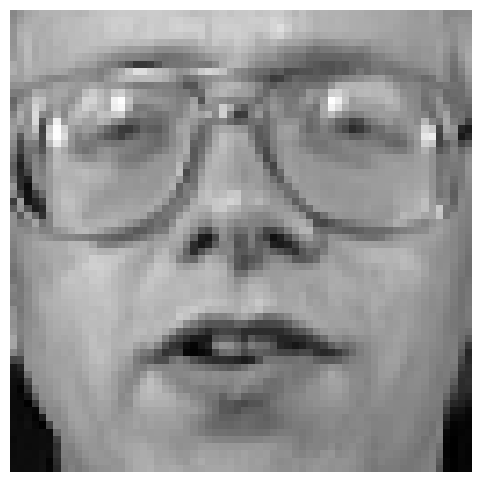

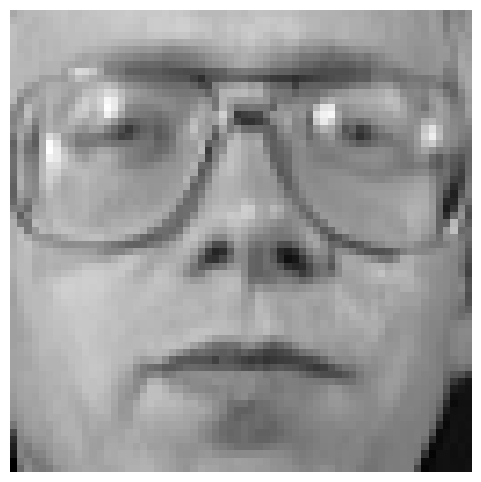

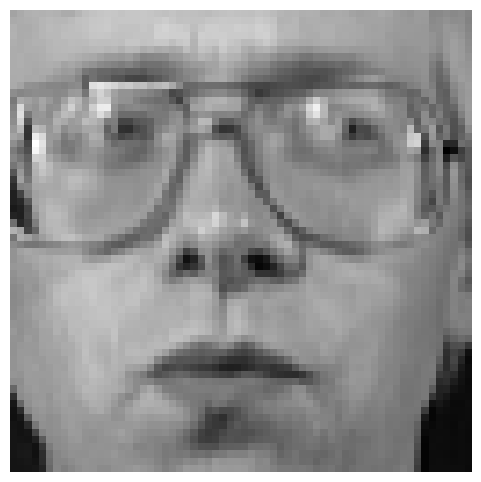

Grupo 7


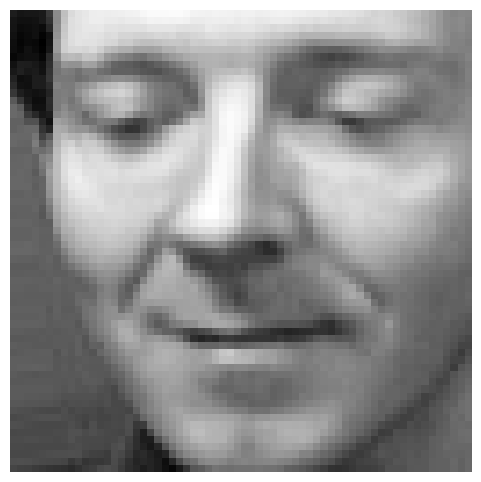

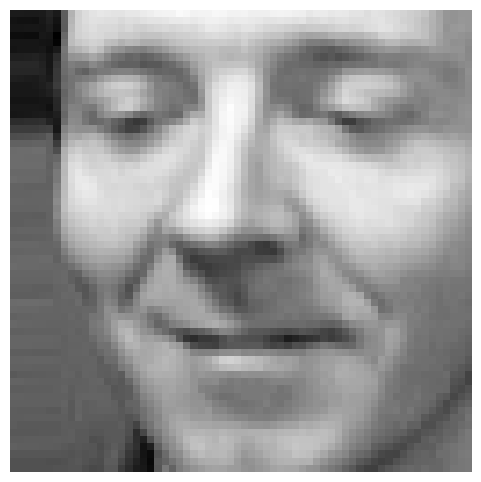

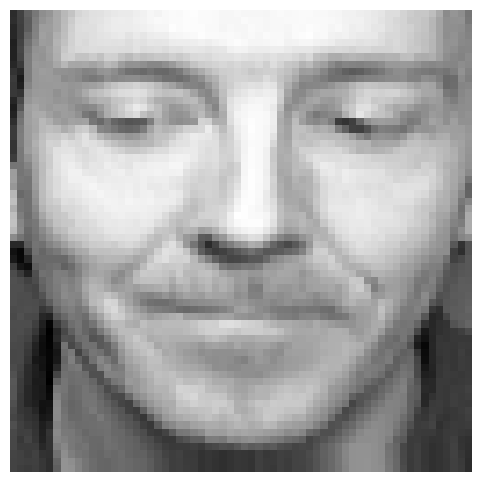

<Figure size 640x480 with 0 Axes>

In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Aplicar K-Means
n_clusters = 8  # Vamos a probar con 5 clústers
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
tags = kmeans.fit_predict(df_reduced)

# Añadir las etiquetas al DataFrame
df['group'] = tags

# Visualizar algunas imágenes de cada grupo
n_samples = 3
plt.figure(figsize=(15, n_clusters * n_samples))

for cluster in range(n_clusters):
    # Seleccionar las primeras 5 imágenes del grupo actual, asegurándose de que haya suficientes imágenes
    samples = df[df['group'] == cluster].iloc[:n_samples, :-1]  # Excluir la columna 'group'
    
    print(f"Grupo {cluster}")
    
    # Verificar el número de muestras disponibles en el grupo
    num_samples = len(samples)
    if num_samples < n_samples:
        print(f"Advertencia: el grupo {cluster} tiene solo {num_samples} muestras.")
    
    for i in range(num_samples):
        display_face(samples.iloc[i])  # Mostrar la imagen de la fila seleccionada

plt.tight_layout()
plt.show()


Tras varias modificaciones parece que 8 grupos diferentes es una buena cantidad de clústeres para dividir las diversas caras, aunque parece que el modelo se está guiando por el ángulo de la foto, si es una foto repetida (que por desgracia parecen haber) o si la persona lleva un accesorio como gafas.
Vamos a usar el puntuaje de siluetas para determinar la calidad de los clústeres creados.

In [44]:
from sklearn.metrics import silhouette_score

# Rango de números de clusters a probar
range_clusters = range(2, 201)  # Por ejemplo de 2 a 200 clusters
silhouette_scores = []

# Para cada número de clusters en el rango
for n_clusters in range_clusters:
    # Aplicar K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    tags = kmeans.fit_predict(df_reduced)  # Usar los datos reducidos por PCA
    
    # Calcular la puntuación de silueta
    score = silhouette_score(df_reduced, tags)
    silhouette_scores.append(score)

max_score = max(silhouette_scores)
best_n_clusters = range_clusters[silhouette_scores.index(max_score)]
print(f"La mayor puntación de silueta es {max_score} y es de {best_n_clusters} clústeres")

La mayor puntación de silueta es 0.2116880537360197 y es de 161 clústeres


Grupo 85
Advertencia: el grupo 85 tiene solo 2 muestras.


<Figure size 1500x48300 with 0 Axes>

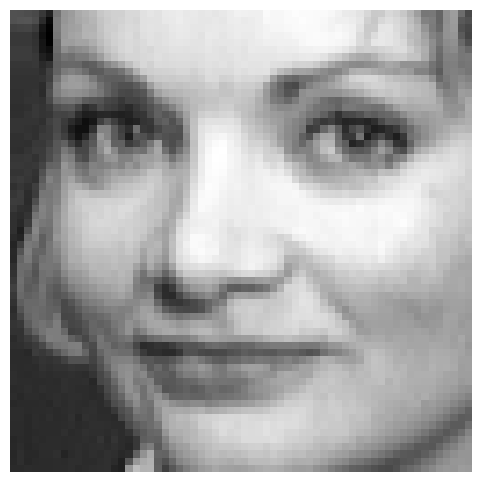

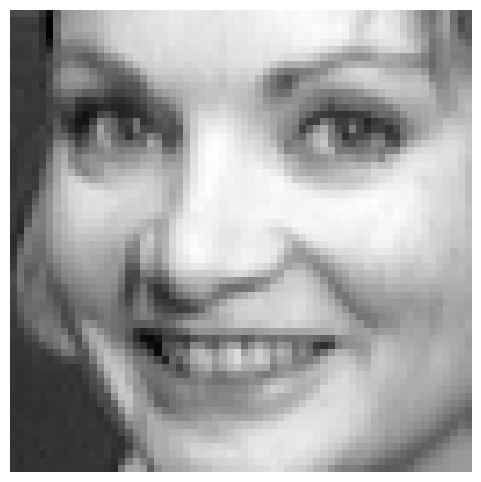

Grupo 72


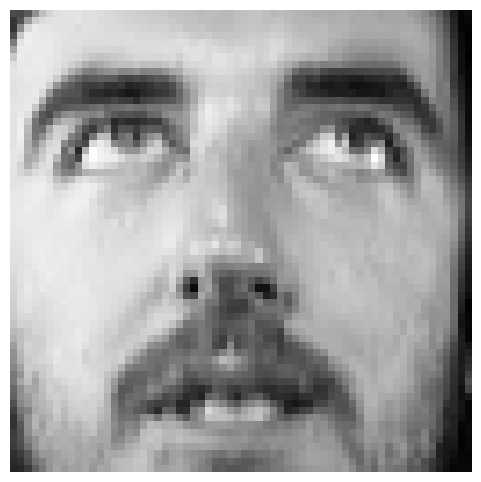

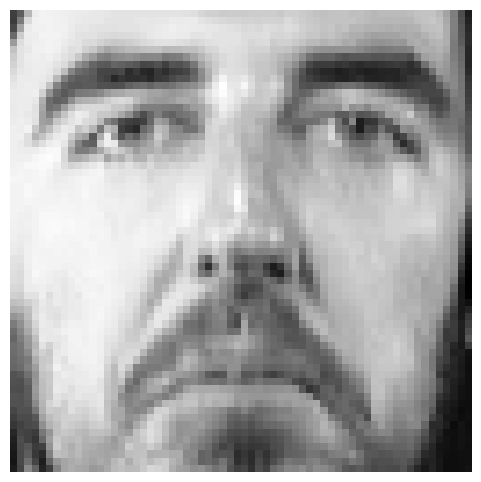

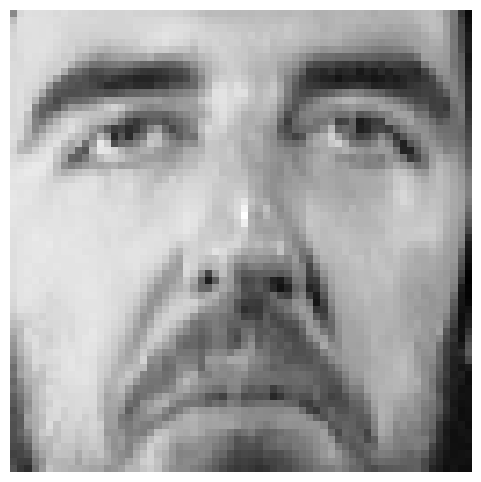

Grupo 149
Advertencia: el grupo 149 tiene solo 2 muestras.


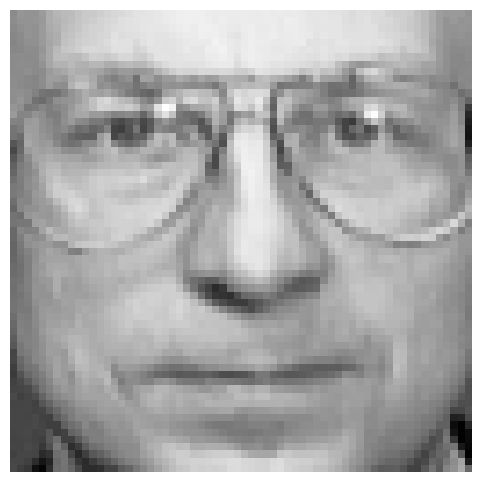

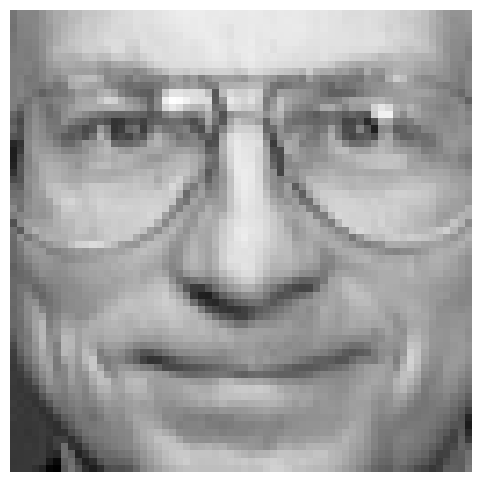

Grupo 30


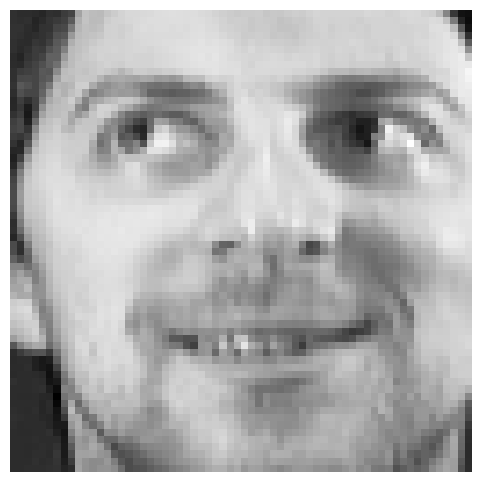

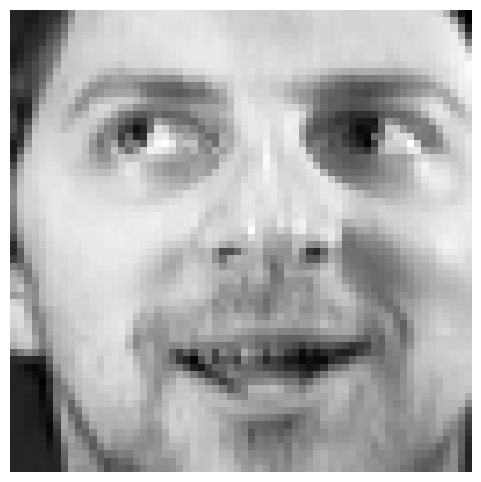

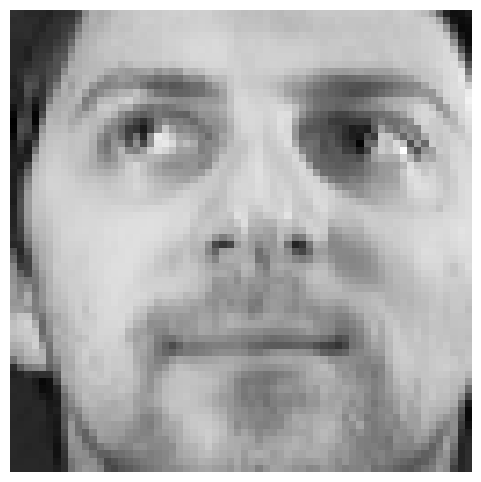

Grupo 60
Advertencia: el grupo 60 tiene solo 1 muestras.


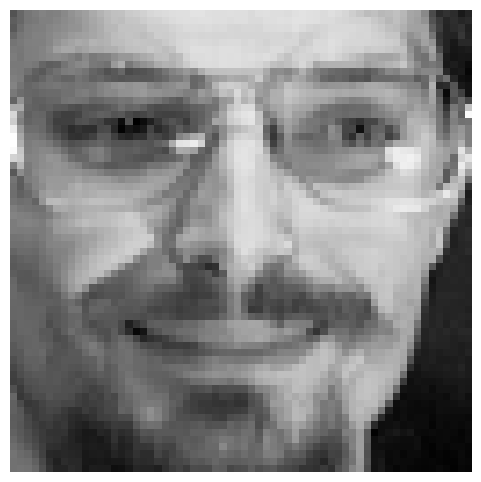

<Figure size 640x480 with 0 Axes>

In [45]:
import random

# Aplicar K-Means
n_clusters = best_n_clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
tags = kmeans.fit_predict(df_reduced)

# Añadir las etiquetas al DataFrame
df['group'] = tags

# Visualizar algunas imágenes de cada grupo
n_samples = 3
plt.figure(figsize=(15, n_clusters * n_samples))

for cluster in range(0,5): # Miramos 5 grupos aleatorios
    sample_cluster = random.randint(1,n_clusters) # Fijamos un grupo aleatorio para visualizar
    samples = df[df['group'] == sample_cluster].iloc[:n_samples, :-1]  # Excluir la columna 'group'
    
    print(f"Grupo {sample_cluster}")
    
    # Verificar el número de muestras disponibles en el grupo
    num_samples = len(samples)
    if num_samples < n_samples:
        print(f"Advertencia: el grupo {sample_cluster} tiene solo {num_samples} muestras.")
    
    for i in range(num_samples):
        display_face(samples.iloc[i])  # Mostrar la imagen de la fila seleccionada

plt.tight_layout()
plt.show()

Vamos a ver si aplicar PCA merece la pena, vamos a usar el mismo método y comparar los tiempo de ejecución el puntuaje de silueta

In [46]:
from sklearn.metrics import silhouette_score

# Rango de números de clusters a probar
range_clusters = range(2, 301)  # Aumentamos a 300 para ver si deja de generalizar con dos grupos
silhouette_scores = []

# Para cada número de clusters en el rango
for n_clusters in range_clusters:
    # Aplicar K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    tags = kmeans.fit_predict(df)  # Usar los datos SIN reducir
    
    # Calcular la puntuación de silueta
    score = silhouette_score(df, tags)
    silhouette_scores.append(score)

max_score_no_PCA = max(silhouette_scores)
best_n_clusters_no_PCA = range_clusters[silhouette_scores.index(max_score_no_PCA)]
print(f"La mayor puntación de silueta es {max_score_no_PCA} y es de {best_n_clusters_no_PCA} clústeres")

La mayor puntación de silueta es 0.5803781015257473 y es de 2 clústeres


El tiempo de ejecución de la búsqueda de clústeres es mayor y parece generalizar a 2 grupos. Aún así muestra una mayor puntuación de silueta, pero no creo que sea adecuado hacer una clasificación binaria de caras dado a que no se van a parecer.

In [47]:
# Ordenar las puntuaciones de silueta de mayor a menor
top_10 = sorted(enumerate(silhouette_scores, 2), key=lambda x: x[1], reverse=True)[:10]

# Imprimir el top 10 de las puntuaciones de silueta y sus respectivos n_clusters
print("Top 10 de Silhouette Scores y sus respectivos n_clusters:")
for n_clusters, score in top_10:
    print(f"n_clusters = {n_clusters}, Silhouette Score = {score:.4f}")

Top 10 de Silhouette Scores y sus respectivos n_clusters:
n_clusters = 2, Silhouette Score = 0.5804
n_clusters = 3, Silhouette Score = 0.5038
n_clusters = 4, Silhouette Score = 0.4566
n_clusters = 5, Silhouette Score = 0.4158
n_clusters = 149, Silhouette Score = 0.3714
n_clusters = 6, Silhouette Score = 0.3705
n_clusters = 151, Silhouette Score = 0.3692
n_clusters = 152, Silhouette Score = 0.3686
n_clusters = 150, Silhouette Score = 0.3685
n_clusters = 155, Silhouette Score = 0.3673


Me parece más apropiado usar una mayor cantidad de grupos para ver los parecidos en los datos en vez de generalizar. Vamos a usar 149 clústeres y visualizar algunos grupos, aunque a ojo humano los grupos hechos con PCA estaban bien (pese a tener un puntuaje de silueta bajo)

Grupo 147
Advertencia: el grupo 147 tiene solo 2 muestras.


<Figure size 1500x44700 with 0 Axes>

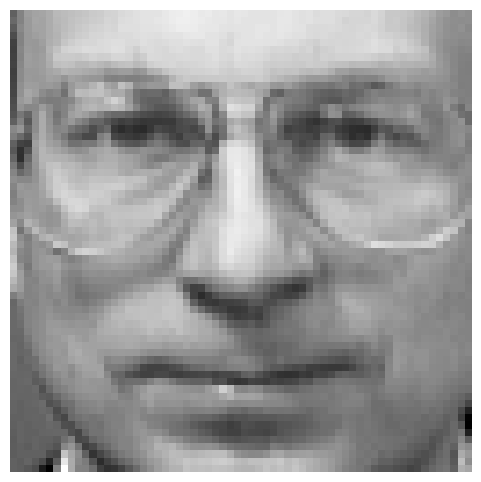

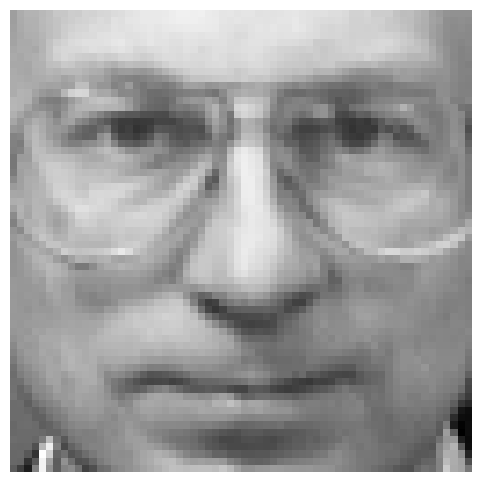

Grupo 24
Advertencia: el grupo 24 tiene solo 2 muestras.


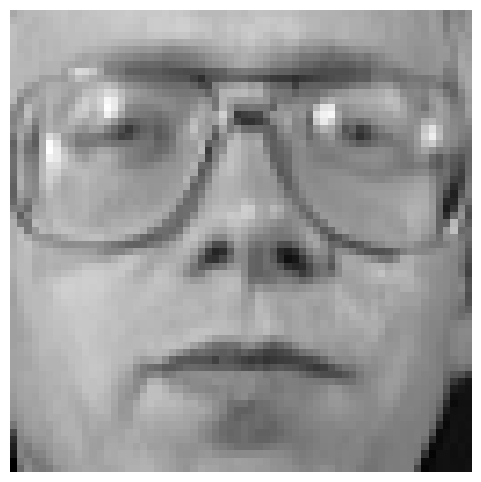

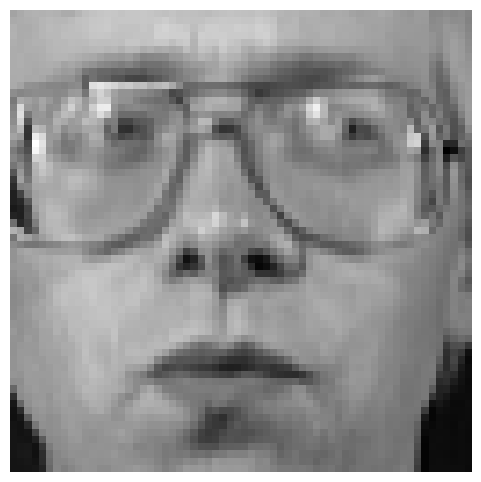

Grupo 64
Advertencia: el grupo 64 tiene solo 2 muestras.


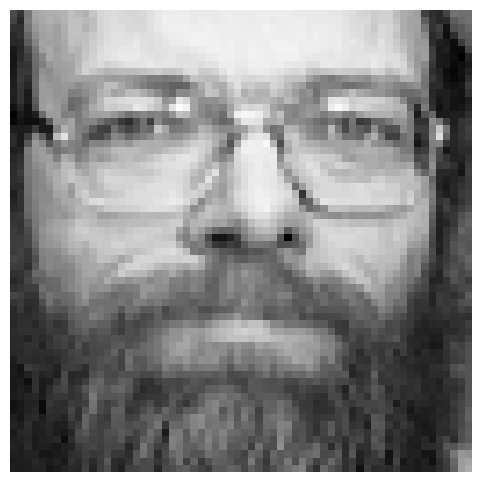

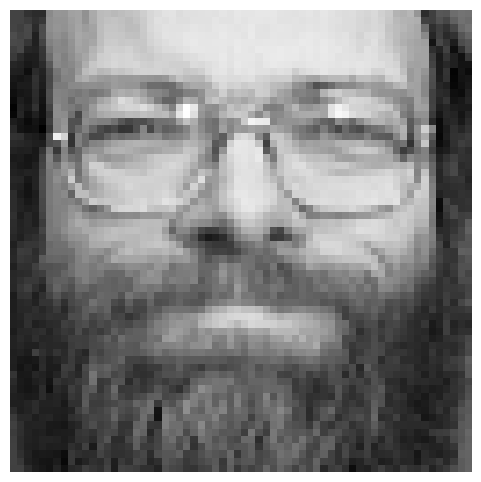

Grupo 129
Advertencia: el grupo 129 tiene solo 2 muestras.


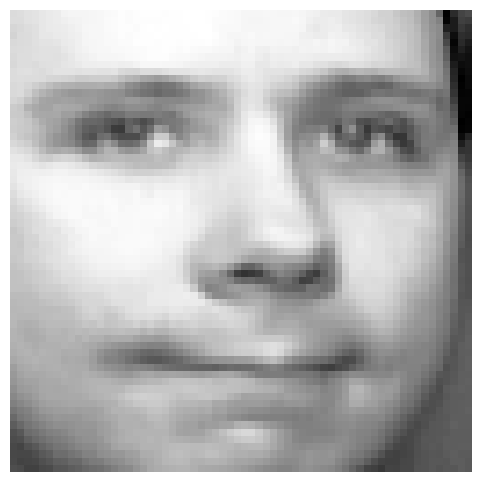

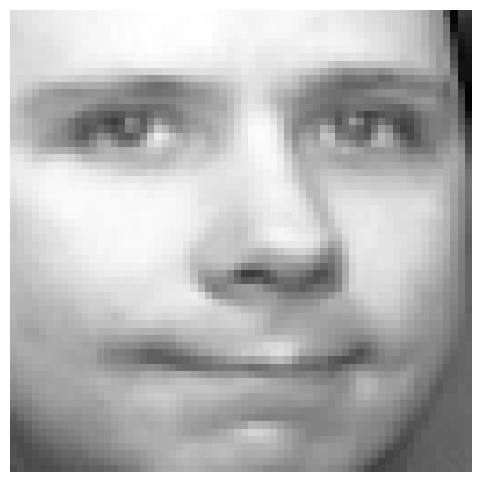

Grupo 11


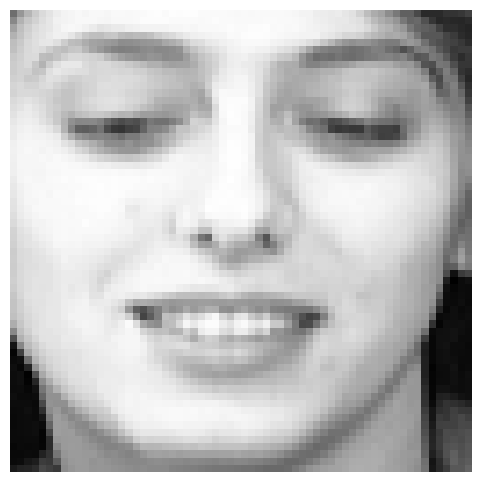

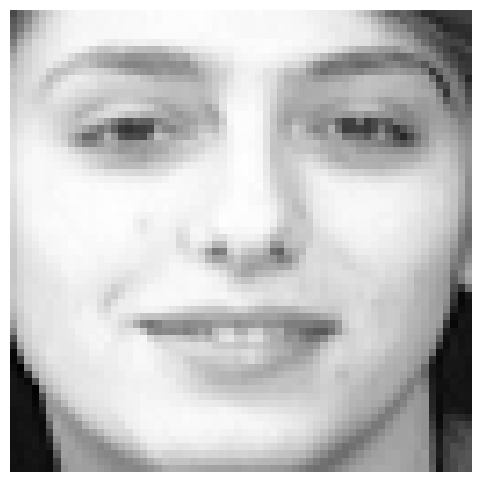

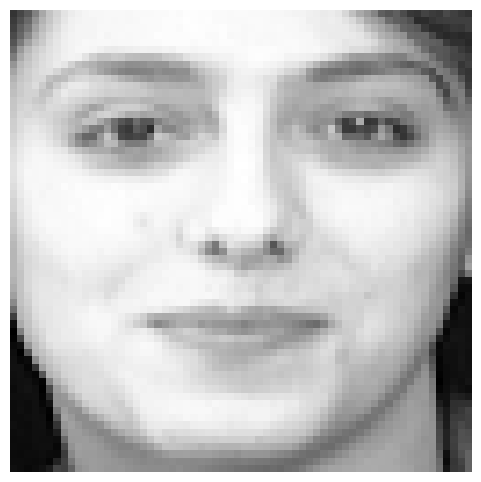

<Figure size 640x480 with 0 Axes>

In [48]:
import random

# Aplicar K-Means
n_clusters = 149 # Lo pongo a mano dado a que no es el mejor valor
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
tags = kmeans.fit_predict(df)

# Añadir las etiquetas al DataFrame
df['group'] = tags

# Visualizar algunas imágenes de cada grupo
n_samples = 3
plt.figure(figsize=(15, n_clusters * n_samples))

for cluster in range(0,5): # Miramos 5 grupos aleatorios
    sample_cluster = random.randint(1,n_clusters) # Fijamos un grupo aleatorio para visualizar
    samples = df[df['group'] == sample_cluster].iloc[:n_samples, :-1]  # Excluir la columna 'group'
    
    print(f"Grupo {sample_cluster}")
    
    # Verificar el número de muestras disponibles en el grupo
    num_samples = len(samples)
    if num_samples < n_samples:
        print(f"Advertencia: el grupo {sample_cluster} tiene solo {num_samples} muestras.")
    
    for i in range(num_samples):
        display_face(samples.iloc[i])  # Mostrar la imagen de la fila seleccionada

plt.tight_layout()
plt.show()

La búsqueda de clústeres cuesta un poco más, pero el entrenamiento del clasificador no se ve casi afectado y la valoración del puntaje de silueta es bastante superior. Creo que no merece la pena aplicar PCA, pero es mejor usar un número alto de clústeres para obtener grupos de 1 a 3 caras de promedio.

## Paso 4: Entrenar modelo final y guardarlo
Vamos a usar el modelo K-Means a 146 clústeres y entrenarlo con los datos sin reducir y vamos a guardar el modelo con joblib

In [50]:
import joblib
import os

best_model = KMeans(n_clusters=146, random_state=42)
df_nuevo = df.drop("group", axis=1)
best_model.fit_predict(df_nuevo)
current_directory = os.getcwd()
relative_path = os.path.join(current_directory, '..', '..', '..', 'recursos', 'modelos', 'faces.pkl')
joblib.dump(best_model, relative_path)

['/home/iabd/Cosas_Proyecto/3.3_Proyecto_ML_G4/src/parte2_ANS/notebooks/../../../recursos/modelos/faces.pkl']